# CMB BBN

In [354]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
from scipy.special import zeta
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18

## Neutron freeze-out

$$\Gamma_n \approx H$$
$$\Gamma_n = \sigma_w n_\nu c$$
$$n_\nu(T_\gamma) = \frac{3}{4}\frac{4}{11}n_\gamma(T_\gamma)\quad (only \nu_e)$$
$$n_\gamma = \frac{2 \zeta(3) (k_B T)^3}{\pi^2 \hbar^3 c^3}$$
$$\sigma_w = (G_F^2 E^2)/(\hbar c)^2 = G_F^2 (k_B T/(\hbar c))^2  = 5\times 10^{-48} \left(\frac{k_B T}{1\,\mathrm{MeV}}\right)^2\,\mathrm{m}^2 $$
$$G_F = 1.166 \times 10^{-5}\,\text{GeV}^{-2}$$
$$g_A = 1.26 \quad\text{(Kolb Turner p.91)}$$
$$ H = \sqrt{\frac{8 \pi^3 G}{90 \hbar^3 c^5}} g_\star^{1/2}(T) (k_B T)^2$$
$$g_\star(100\,\mathrm{MeV} > T > 511\,\mathrm{keV}) = 10.75$$
$$g_\star(T < 511\,\mathrm{keV}) = 3.36$$

In [2]:
T0 = 2.726 * u.K  # K
Qn = 1.29 * u.MeV
Neff = 3.046
gstar = 10.75  # at m_e < T < 100 MeV
gstar_after = 3.36  # at m_e > T
GF = 1.166e-5 / (u.GeV**2)
gA = 1.26
taun = 878.4 * u.s

In [3]:
def ng(T):
    return 2 * zeta(3) * (const.k_B * T)**3 / (np.pi**2 * const.hbar**3 * const.c**3)

ng(T0).to(1/u.cm**3)

<Quantity 410.95293609 1 / cm3>

In [4]:
# 3/4 for fermion nature, only 1 of the 3 flavors
# then 2 polarisations for photons vs g=2 for massless neutrinos
def nnu_e(T):
    return 4*ng(T)/11 * (3/4) #* Neff

nnu_e(T0).to(1/u.cm**3)

<Quantity 112.07807348 1 / cm3>

In [5]:
def H(T, gstar=gstar):
    return (np.sqrt(8*np.pi**3*const.G*gstar/(90*const.hbar**3*const.c**5))*(const.k_B * T)**2).to(1/u.s)

T_1MeV = (1 * u.MeV / const.k_B).to(u.K)
T_10MeV = (10 * u.MeV / const.k_B).to(u.K)
H(T_1MeV)  # OK with Kolb Turner formula p.91

<Quantity 0.67734578 1 / s>

In [6]:
def t_to_T(t, gstar=gstar):
    return (1/const.k_B*np.sqrt(1/(2*t)*np.sqrt(90*const.hbar**3*const.c**5/(8*np.pi**3*const.G*gstar) ))).to(u.K)

def T_to_t(T, gstar=gstar):
    return 1/(2*H(T, gstar=gstar))

t_to_T(10*u.s), T_to_t(t_to_T(10*u.s)), t_to_T(1*u.s)

(<Quantity 3.15287605e+09 K>, <Quantity 10. s>, <Quantity 9.97026951e+09 K>)

## Neutrino temperature and time to temperature accurate conversion

See Weinberg p.540 p.529

In [388]:
T_Weinberg = np.array([1e12, 6e11, 3e11, 2e11, 1e11, 6e10, 3e10, 2e10, 1e10, 6e9, 3e9, 2e9, 1e9, 3e8, 1e8, 1e7, 1e6, 1e5, 1e4, 4e3])
a_Weinberg = np.array([1.9e-12, 3.2e-12, 6.4e-12, 9.6e-12, 1.9e-11, 3.2e-11, 6.4e-11, 9.6e-11, 1.9e-10, 3.1e-10, 5.9e-10, 8.3e-10, 2.6e-9, 9e-9, 2.7e-8, 2.7e-7, 2.7e-6, 2.7e-5, 2.7e-4, 6.3e-4])
Tnu_Weinberg = T_Weinberg / np.array([1, 1, 1, 1, 1, 1, 1.001, 1.002, 1.008, 1.022, 1.081, 1.159, 1.346, 1.401, 1.401,1.401,1.401,1.401,1.401,1.401])
t_Weinberg = np.array([1e-4, 1.94e-4, 1.129e-3, 2.61e-3, 1.078e-2, 3.01e-2, 0.1209, 0.273, 1.103, 3.14, 13.83, 35.2, 1.82e2, 2.08e3, 1.92e4, 1.92e6,1.92e8,1.92e10,1.92e12,1.2e13])

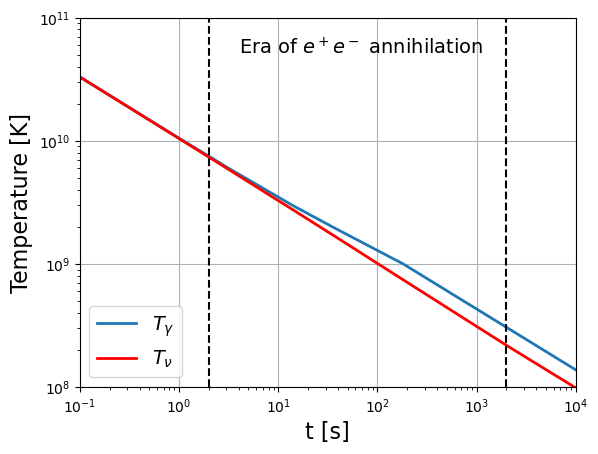

In [389]:
fig = plt.figure()
plt.loglog(t_Weinberg, T_Weinberg, lw=2, label=r"$T_\gamma$")
plt.loglog(t_Weinberg, Tnu_Weinberg, lw=2, color="r", label=r"$T_\nu$")
plt.xlim(1e-1, 1e4)
plt.ylim(1e8, 1e11)
plt.axvline(2, linestyle="--", color="k")
plt.axvline(2e3, linestyle="--", color="k")
plt.legend(fontsize=14)
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("Temperature [K]", fontsize=16)
plt.text(4e0, 5e10, "Era of $e^+ e^-$ annihilation", fontsize=14)
plt.grid()
plt.show()

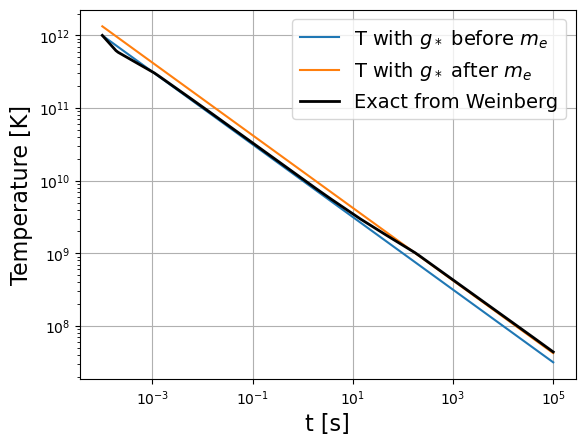

In [424]:
def T_to_t_Weinberg(T):
    return np.exp(np.interp(np.log(T), np.log(T_Weinberg[::-1]), np.log(t_Weinberg[::-1])))*u.s

def t_to_T_Weinberg(t):
    return np.exp(np.interp(np.log(t), np.log(t_Weinberg), np.log(T_Weinberg)))*u.K

ttt = np.logspace(-4, 5, 200) * u.s

fig = plt.figure()
plt.loglog(ttt, t_to_T(ttt, gstar=gstar), label="T with $g_*$ before $m_e$")
plt.loglog(ttt, t_to_T(ttt, gstar=gstar_after), label="T with $g_*$ after $m_e$")
plt.loglog(ttt, t_to_T_Weinberg(ttt.value), "k-", lw=2, label="Exact from Weinberg")
plt.grid()
plt.legend(fontsize=14)
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("Temperature [K]", fontsize=16)
plt.show()

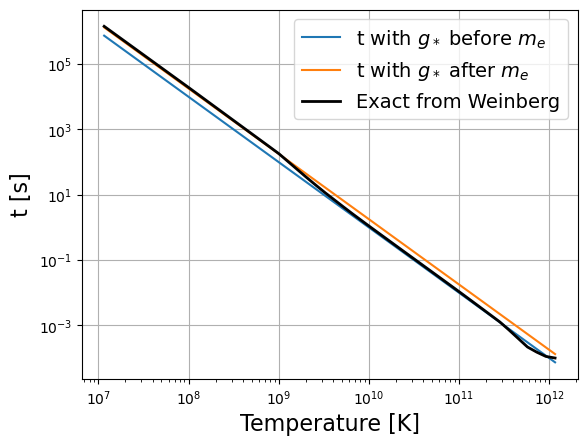

In [425]:
TTT = (np.logspace(3, 8, 50) * u.eV/ const.k_B).to(u.K)

fig = plt.figure()
plt.loglog(TTT, T_to_t(TTT, gstar=gstar), label="t with $g_*$ before $m_e$")
plt.loglog(TTT, T_to_t(TTT, gstar=gstar_after), label="t with $g_*$ after $m_e$")
plt.loglog(TTT, T_to_t_Weinberg(TTT.value), "k-", lw=2, label="Exact from Weinberg")
plt.grid()
plt.legend(fontsize=14)
plt.ylabel("t [s]", fontsize=16)
plt.xlabel("Temperature [K]", fontsize=16)
plt.show()

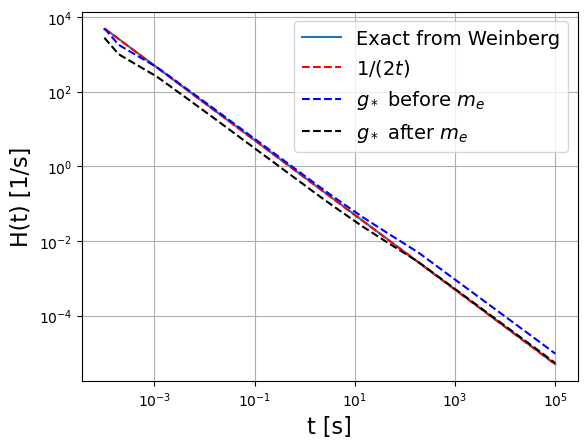

In [444]:
T_fine = np.logspace(np.log10(np.min(T_Weinberg)), np.log10(np.max(T_Weinberg)), 200)
t_fine = np.logspace(np.log10(np.min(t_Weinberg)), np.log10(np.max(t_Weinberg)), 200)
a_fine = np.logspace(np.log10(np.min(a_Weinberg)), np.log10(np.max(a_Weinberg)), 200)
H_fine = np.gradient(a_fine, t_fine) / a_fine

def Ht_Weinberg(t):
    return np.interp(t, t_fine, H_fine) / u.s

def HT_Weinberg(T):
    return np.interp(T, T_fine, H_fine) / u.s

fig = plt.figure()
plt.loglog(ttt, Ht_Weinberg(ttt.value), label="Exact from Weinberg")
plt.loglog(ttt, 1/(2*ttt), "r--", label="$1/(2t)$")
plt.loglog(ttt, H(t_to_T_Weinberg(ttt.value), gstar=gstar), "b--", label="$g_*$ before $m_e$")
plt.loglog(ttt, H(t_to_T_Weinberg(ttt.value), gstar=gstar_after), "k--", label="$g_*$ after $m_e$")
plt.grid()
plt.legend(fontsize=14)
plt.xlabel("t [s]", fontsize=16)
plt.ylabel("H(t) [1/s]", fontsize=16)
plt.show()

## Orders of magnitude

From equilibrium equations and rate with $G_F$ and $g_A$ :

In [114]:
# at 1 MeV
sigma_np = (((GF**2)  * (1+3*gA**2)  * 1*u.MeV**2).to(1/u.GeV**2)* (const.hbar * const.c)**2).to(u.m**2)
sigma_np

<Quantity 3.05072871e-47 m2>

In [115]:
def Gamma_n(T):
    return (sigma_np * (const.k_B * T / (1*u.MeV))**2 * nnu_e(T) * const.c).to(1/u.s)

1/Gamma_n(0.8*T_1MeV)

<Quantity 38.59236 s>

Freeze out temperature

In [116]:
from scipy.optimize import fsolve
Tfreeze = fsolve(lambda T: Gamma_n(T*u.K)-H(T*u.K), [1e8, 1e12])[1]
(Tfreeze*u.K * const.k_B).to(u.MeV)

<Quantity 2.04607038 MeV>

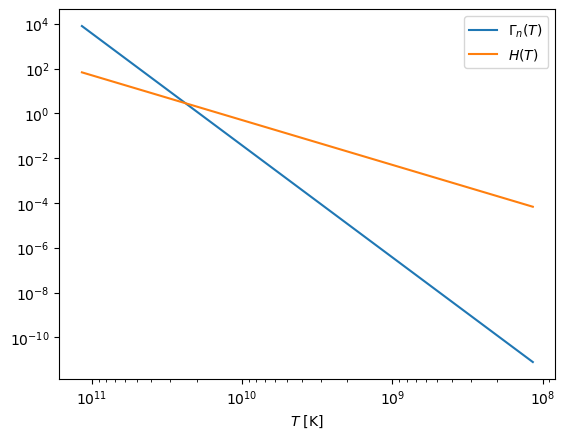

In [447]:
TT = (np.logspace(4, 7, 50) * u.eV/ const.k_B).to(u.K)

fig = plt.figure()
plt.plot(TT, Gamma_n(TT), label="$\Gamma_n(T)$")
plt.plot(TT, H(TT), label="$H(T)$")
plt.gca().invert_xaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("$T$ [K]")
plt.show()

## Exact computation

The freeze-out temperature obtained with orders of magnitude is too high to explain the helium aboundance (by a factor of 3, but here numerical factors do count). We now use exact (Weinberg integrals) and semi-exact (Dodelson approximation) methods.

Using Weinberg and Dodelson equations

Check equality of constant $g_V$ in Weinberg eq 15.7.9 p.547 with with Fermi constant $G_F$

In [59]:
gV = 1.418e-49*u.erg*u.cm**3
(gV/(const.hbar*const.c)**3).to(u.GeV**-2)

<Quantity 1.15187785e-05 1 / GeV2>

In [60]:
GF

<Quantity 1.166e-05 1 / GeV2>

In [61]:
A=(((gV/(const.hbar*const.c)**3)**2+3*(gA*gV/(const.hbar*const.c)**3)**2)/(2*np.pi**3)).to(u.GeV**-4)
A #*7/15*np.pi**4

<Quantity 1.23301053e-11 1 / GeV4>

In Weinberg, neutron life time is 1013s but current value if 878s. We rescale its amplitude constant:

In [63]:
# rescale with current neutron life as Weinberg
A = GF**2*(1+3*gA**2)/(2*np.pi**3) * 1013/878
A

<Quantity 1.45769265e-11 1 / GeV4>

Computation of interaction rates:

In [119]:
from scipy.integrate import quad
me = 511*u.keV

integrand_lpn = lambda q, T: (A*np.sqrt(1-(me/(Qn+q))**2)*(Qn+q)**2*(q)**2/(1+np.exp(-q/(const.k_B*T)))/(1+np.exp((Qn+q)/(const.k_B * T)))).to(u.dimensionless_unscaled)

integrand_lnp = lambda q, T: (A*np.sqrt(1-(me/(Qn+q))**2)*(Qn+q)**2*(q)**2/(1+np.exp(q/(const.k_B*T)))/(1+np.exp(-(Qn+q)/(const.k_B * T)))).to(u.dimensionless_unscaled)

def lnp(T):
    intp = quad(lambda q: integrand_lnp(q*u.MeV,T), (-Qn+me).to(u.MeV).value, np.inf)[0]
    intm = quad(lambda q: integrand_lnp(q*u.MeV,T), -np.inf, (-Qn-me).to(u.MeV).value)[0]
    return ((intp+intm)*u.MeV/const.hbar).to(1/u.s)

def lpn(T):
    intp = quad(lambda q: integrand_lpn(q*u.MeV,T), (-Qn+me).to(u.MeV).value, np.inf)[0]
    intm = quad(lambda q: integrand_lpn(q*u.MeV,T), -np.inf, (-Qn-me).to(u.MeV).value)[0]
    return ((intp+intm)*u.MeV/const.hbar).to(1/u.s)

def lambda_np_Bernstein(T):  # Dodeslon p.67
    x = Qn / (const.k_B * T)
    return (255/(taun*x**5)*(12+6*x+x**2)).to(1/u.s)

lnp(0.8*T_1MeV), lpn(0.8*T_1MeV) , lambda_np_Bernstein(0.8*T_1MeV), H(0.8*T_1MeV)

(<Quantity 0.65549597 1 / s>,
 <Quantity 0.13069837 1 / s>,
 <Quantity 0.64641477 1 / s>,
 <Quantity 0.4335013 1 / s>)

Check that $\lambda_{pn} \sim \lambda_{np} e^{-Qn/T}$ :

In [120]:
lnp(0.8*T_1MeV) * np.exp(-Qn/(const.k_B * 0.8 * T_1MeV))

<Quantity 0.13069837 1 / s>

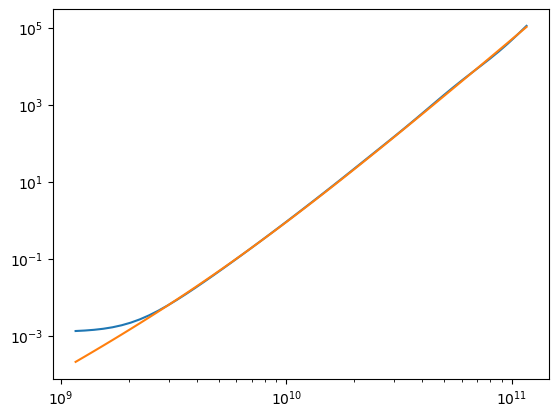

In [121]:
TT = (np.logspace(5, 7, 50) * u.eV/ const.k_B).to(u.K)

fig = plt.figure()
plt.plot(TT, np.array([lnp(T).value for T in TT])/u.s)
plt.plot(TT, lambda_np_Bernstein(TT))
plt.yscale("log")
plt.xscale("log")
plt.show()

Solve

In [493]:
from scipy.integrate import odeint

def dXndt_notaun(Xn, t):
    return (lambda_np_Bernstein(t_to_T(t*u.s))*( (1-Xn)*np.exp(-Qn/(const.k_B*t_to_T(t*u.s))) - Xn)).value

def dXndt(Xn, t):
    # return (lambda_np_Bernstein(t_to_T(t*u.s))*( (1-Xn)*np.exp(-Qn/(const.k_B*t_to_T(t*u.s))) - Xn) - Xn/taun).value
    # return (lnp(t_to_T(t*u.s))*(-Xn + np.exp(-Qn/(const.k_B * t_to_T(t*u.s))) * (1-Xn))).value
    return (-Xn * lnp(t_to_T(t*u.s)) + lpn(t_to_T(t*u.s)) * (1-Xn)).value
    # return (-Xn * lnp(t_to_T_Weinberg(t)) + lpn(t_to_T_Weinberg(t)) * (1-Xn)).value  # slower

tt = np.logspace(-3, 3, 200)

Xn_sol = odeint(dXndt, 1/(1+np.exp(Qn/(const.k_B * t_to_T(tt[0]*u.s)))), tt)
Xnt = lambda t: np.interp(t, tt*u.s, Xn_sol[:, 0])
XnT = lambda T: np.interp(T, t_to_T(tt[::-1]*u.s), Xn_sol[:, 0][::-1])

Xn_sol_notaun = odeint(dXndt_notaun, 1/(1+np.exp(Qn/(const.k_B * t_to_T(tt[0]*u.s)))), tt)
Xnt_notaun = lambda t: np.interp(t, tt*u.s, Xn_sol_notaun[:, 0])
XnT_notaun = lambda T: np.interp(T, t_to_T(tt[::-1]*u.s), Xn_sol_notaun[:, 0][::-1])

XnT(T_1MeV), Xnt(0.73*u.s)

(0.2546931106785803, 0.2554279084910855)

In [494]:
dXndt(XnT(1e10*u.K), T_to_t(1e10*u.K).value), XnT(1e10*u.K), H(1e10*u.K),1/(2*T_to_t(1e10*u.K)), T_to_t(1e10*u.K)

(-0.059484795266252305,
 0.23618253503009692,
 <Quantity 0.50298636 1 / s>,
 <Quantity 0.50298636 1 / s>,
 <Quantity 0.99406274 s>)

In [495]:
-dXndt(Xnt(1*u.s), 1), Xnt(1*u.s), H(t_to_T(1*u.s)), 1/(2*1*u.s), (const.k_B*t_to_T(1*u.s)).to(u.MeV)

(0.0590577858660713,
 0.23588394768970708,
 <Quantity 0.5 1 / s>,
 <Quantity 0.5 1 / s>,
 <Quantity 0.85917135 MeV>)

Differential equation 3.27 from Dodelson p.67

In [496]:
def dXndx(Xn, x):
    T = (Qn / (const.k_B * x)).to(u.K)
    return (x*lnp(T)/H(Qn/const.k_B)*(np.exp(-x) - Xn*(1+np.exp(-x)))).value

xx = np.logspace(-3, 3, 200)
XnDodelson_sol = odeint(dXndx, 1/(1+np.exp(xx[0])), xx)
XnDodelson_sol

array([[ 4.99750000e-01],
       [ 4.99732027e-01],
       [ 4.99712762e-01],
       [ 4.99692113e-01],
       [ 4.99669978e-01],
       [ 4.99646252e-01],
       [ 4.99620821e-01],
       [ 4.99593561e-01],
       [ 4.99564342e-01],
       [ 4.99533022e-01],
       [ 4.99499450e-01],
       [ 4.99463465e-01],
       [ 4.99424893e-01],
       [ 4.99383548e-01],
       [ 4.99339230e-01],
       [ 4.99291727e-01],
       [ 4.99240808e-01],
       [ 4.99186229e-01],
       [ 4.99127727e-01],
       [ 4.99065019e-01],
       [ 4.98997802e-01],
       [ 4.98925754e-01],
       [ 4.98848526e-01],
       [ 4.98765746e-01],
       [ 4.98677015e-01],
       [ 4.98581904e-01],
       [ 4.98479956e-01],
       [ 4.98370679e-01],
       [ 4.98253546e-01],
       [ 4.98127992e-01],
       [ 4.97993412e-01],
       [ 4.97849157e-01],
       [ 4.97694530e-01],
       [ 4.97528788e-01],
       [ 4.97351130e-01],
       [ 4.97160700e-01],
       [ 4.96956582e-01],
       [ 4.96737795e-01],
       [ 4.9

In [497]:
XnDodelson_sol[-1]

array([-3.83979787e-11])

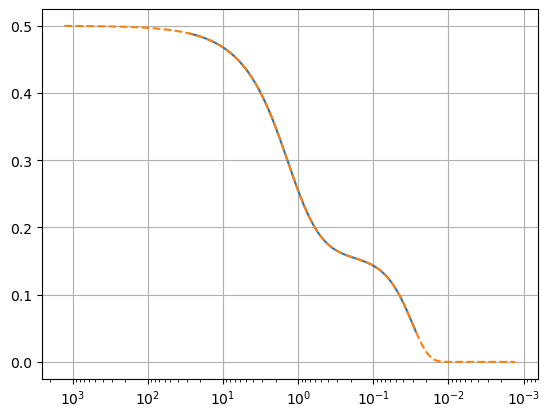

In [498]:
fig = plt.figure()
#plt.plot((TT*const.k_B).to(u.MeV), XnT(TT))
plt.plot((const.k_B*t_to_T(tt*u.s)).to(u.MeV), Xn_sol)
plt.plot((Qn / xx).to(u.MeV), XnDodelson_sol, '--')
#plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid()
plt.show()

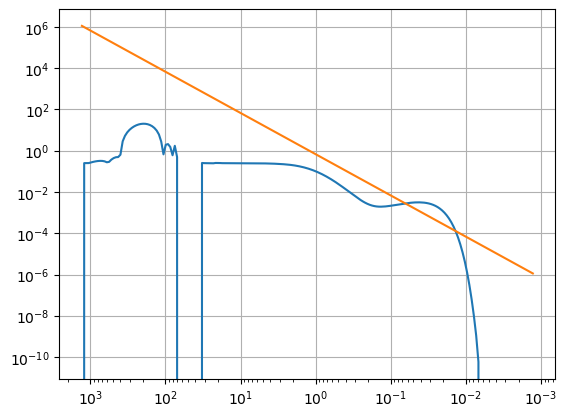

In [499]:


fig = plt.figure()
#plt.plot((TT*const.k_B).to(u.MeV), XnT(TT))
plt.plot((Qn / xx).to(u.MeV), [-dXndx(XnDodelson_sol[k], x) for k,x in enumerate(xx)])
plt.plot((Qn / xx).to(u.MeV), H((Qn / xx / const.k_B).to(u.K)), label="$H(T)$")
plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid()
plt.show()



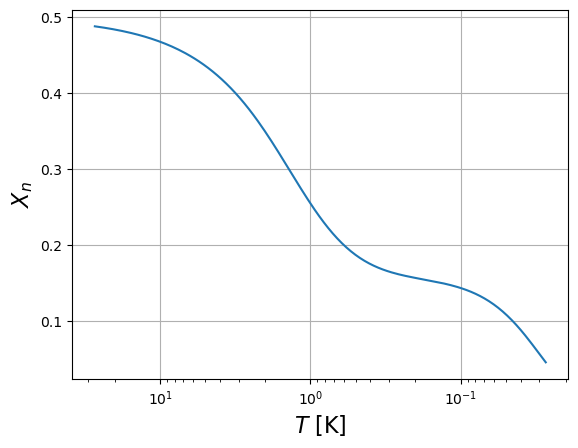

In [500]:
fig = plt.figure()
plt.plot((t_to_T(tt*u.s)*const.k_B).to(u.MeV), Xn_sol)
#plt.plot((t_to_T(tt*u.s)*const.k_B).to(u.MeV), XnDodelson_sol)
#plt.plot((Qn / xx).to(u.MeV), XnDodelson_sol)
#plt.plot((t_to_T(tt*u.s)*const.k_B).to(u.MeV), XnT(t_to_T(tt*u.s)))
#plt.plot((TT*const.k_B).to(u.MeV), XnT(TT))
#plt.plot((TT*const.k_B).to(u.MeV), Xnt(T_to_t(TT)))
#plt.plot((Qn / xx).to(u.MeV), Xn_sol)
#plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid()
plt.xlabel("$T$ [K]", fontsize=16)
plt.ylabel("$X_n$", fontsize=16)

plt.show()

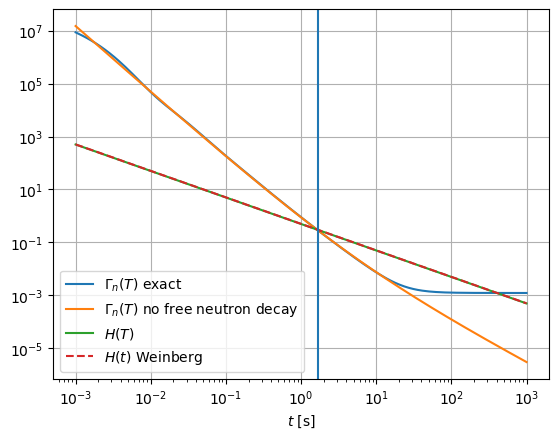

In [501]:
TTT = t_to_T(tt*u.s)

fig = plt.figure()
#plt.plot(tt, np.array([-dXndt(Xnt(t*u.s), t) for t in tt])/u.s, label="$\Gamma_n(T)$")
plt.plot(tt, np.array([lnp(T).value for T in TTT])/u.s, label="$\Gamma_n(T)$ exact")
plt.plot(tt, lambda_np_Bernstein(TTT), label="$\Gamma_n(T)$ no free neutron decay")
#plt.plot(tt, np.array([lnp(T).value+lpn(T).value for T in TTT])/u.s, label="$\Gamma_n(T)$")
plt.plot(tt, 1/(2*tt), label="$H(T)$")
plt.plot(tt, Ht_Weinberg(tt), "--", label="$H(t)$ Weinberg")
#plt.gca().invert_xaxis()
plt.axvline(1.7)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid()
plt.xlabel("$t$ [s]")
plt.show()

In [502]:
lnp(T_1MeV), T_1MeV

(<Quantity 1.77604491 1 / s>, <Quantity 1.16045181e+10 K>)

In [503]:
from scipy.optimize import fsolve
Tfreeze = fsolve(lambda T: lambda_np_Bernstein(T*u.K).value-H(T*u.K).value, [1e8, 1e12])[1] * u.K
#Tfreeze = fsolve(lambda T: lnp(T*u.K).value-H(T*u.K).value, [1e8, 1e12])[1] * u.K
(Tfreeze * const.k_B).to(u.MeV), Tfreeze

(<Quantity 0.67481545 MeV>, <Quantity 7.83090811e+09 K>)

In [504]:
Tfreeze = t_to_T_Weinberg(fsolve(lambda t: lambda_np_Bernstein(t_to_T_Weinberg(t)).value-Ht_Weinberg(t).value, [1e-2, 1e2])[0])
(Tfreeze * const.k_B).to(u.MeV), Tfreeze

(<Quantity 0.64293845 MeV>, <Quantity 7.46099084e+09 K>)

In [505]:
def ratio_np(T):
    return XnT(T) / (1-XnT(T))

def ratio_np_notaun(T):
    return XnT_notaun(T) / (1-XnT_notaun(T))

npfreeze = ratio_np(Tfreeze)
npfreeze

0.25901803917730154

Proportion of neutrino converging after $T_{freeze}$:

In [506]:
npnuc = ratio_np(Tnuc)
npnuc_notaun = ratio_np_notaun(Tnuc)
npnuc, npnuc_notaun 

(0.1473770372344492, 0.17566473397076532)

## Deutérium ratio

In [507]:
BD = 2.22 * u.MeV
mn = 939.6 * u.MeV
Omegab0 = Planck18.Ob0
age = Planck18.lookback_time(np.inf)
rhoc0 = (3 * Planck18.H0**2 / (8 * np.pi * const.G) / const.m_p).to(1/u.m**3)

In [508]:
def nb(z):
    return Omegab0 * rhoc0 * (1+z)**3

eta = nb(0) / ng(T0)
eta

<Quantity 6.12602549e-10>

In [509]:
def ratio_Dn(T):
    # return (6*0.2*np.pi**3/2*eta*(const.k_B * T/(mn*const.c**2))**(3/2)*np.exp(BD/(const.k_B*T))).to(u.dimensionless_unscaled)
    return (6*(1-XnT(T))*2*zeta(3)*(np.pi/2)*eta*(const.k_B * T/mn)**(3/2)*np.exp(BD/(const.k_B*T))).to(u.dimensionless_unscaled)

ratio_Dn(Tfreeze)

<Quantity 6.23428334e-12>

In [510]:
from scipy.optimize import brentq
Tnuc = brentq(lambda T: ratio_Dn(T*u.K)-1, 1e8, 1e10) * u.K
Tnuc

<Quantity 7.9206428e+08 K>

In [511]:
(const.k_B * Tnuc).to(u.MeV)

<Quantity 0.06825482 MeV>

In [512]:
tnuc = T_to_t(Tnuc, gstar=gstar_after)
tnuc = T_to_t_Weinberg(Tnuc.value)
tnuc

<Quantity 291.68853684 s>

In [513]:
T_to_t(0.1*u.MeV/const.k_B, gstar=gstar_after), T_to_t_Weinberg((0.1*u.MeV/const.k_B).to(u.K).value)

(<Quantity 132.03654981 s>, <Quantity 127.90464621 s>)

In [514]:
npnuc = ratio_np(Tnuc)
Xnnuc = XnT(Tnuc)
npfreeze, npnuc, Xnnuc

(0.25901803917730154, 0.14734740090432036, 0.12842439943489092)

Maximum helium 4 abondance (if all neutrons end in helium nuclei, no D nor Li nor...):

In [515]:
def Yp(np):
    return 2*np/(1+np)

Yp(npnuc)

0.25684879886978185

## Plots

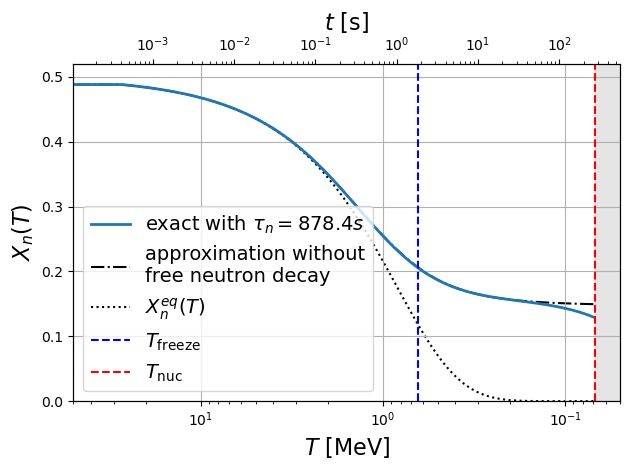

In [557]:
#| label: BBN_Xn

TT = (np.logspace(np.log10(7e4), np.log10(5e7), 100) * u.eV/ const.k_B).to(u.K)
TTafter = (np.logspace(np.log10(7e4), np.log10(5e6), 100) * u.eV/ const.k_B).to(u.K)
npeq = np.exp(-Qn/(const.k_B * TTafter))

fig = plt.figure()
plt.plot((TT*const.k_B).to(u.MeV), XnT(TT), label=rf"exact with $\tau_n={taun:.1f}$", lw=2)
plt.plot((TT*const.k_B).to(u.MeV), XnT_notaun(TT), linestyle="-.", label="approximation without\nfree neutron decay", zorder=-2, color="k")
plt.plot((TTafter*const.k_B).to(u.MeV), npeq/(1+npeq), linestyle="dotted", label=r"$X_n^{eq}(T)$", zorder=-3, color="k")
#plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("$T$ [MeV]", fontsize=16)
plt.ylabel("$X_n(T)$", fontsize=16)
plt.axvline((Tfreeze * const.k_B).to(u.MeV).value, color="b", linestyle="--", label="$T_\mathrm{freeze}$")
plt.axvline((Tnuc * const.k_B).to(u.MeV).value, color="r", linestyle="--", label="$T_\mathrm{nuc}$")
plt.legend(fontsize=14, ncol=1)
plt.axvspan((Tnuc * const.k_B).to(u.MeV).value, 5e-2, alpha=0.2, color="gray")  #horizontal shading
plt.xlim((50, 5e-2))
plt.ylim(0.0, 0.52)
plt.grid()

secax = plt.gca().twiny()
ttt = T_to_t_Weinberg(TT.value)
secax.plot(ttt, Xnt(ttt), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [s]', fontsize=16)
fig.tight_layout()
plt.show()

In [563]:
def ratio_mass_Dp(T):
    return 2*ratio_Dn(T)/(1+ratio_np(T))

def ratio_mass_Hp(T):
    if T > Tnuc:
        return 1/(1+ratio_np(T))
    else:
        return 1/(1+ratio_np(Tnuc)) - Yp(npnuc)/2  # half the mass of helium must be subtracted (2 protons)

def ratio_mass_Hep(T):
    if T > Tnuc:
        return 0
    else:
        return Yp(npnuc)

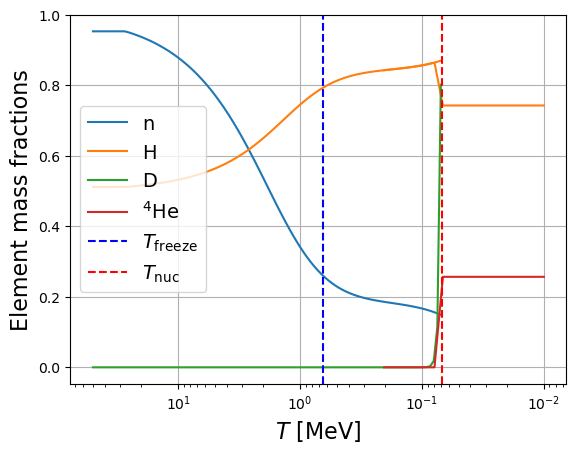

In [564]:
#| label: BBN_Yp

fig = plt.figure()
plt.plot((TT*const.k_B).to(u.MeV), ratio_np(TT), label="n")
p = plt.plot((TT*const.k_B).to(u.MeV), [ratio_mass_Hp(T) for T in TT], linestyle="-", label="H")
TTHe = (np.logspace(4, np.log10(3*(const.k_B * Tnuc).to(u.eV).value), 20) * u.eV/ const.k_B).to(u.K)
plt.plot((TTHe*const.k_B).to(u.MeV), [ratio_mass_Hp(T) for T in TTHe], linestyle="-", color=p[0].get_color())
plt.plot((TT*const.k_B).to(u.MeV), ratio_mass_Dp(TT), linestyle="-", label="D")
plt.plot((TTHe*const.k_B).to(u.MeV), [ratio_mass_Hep(T) for T in TTHe], linestyle="-", label="$^4$He")
plt.axvline((Tfreeze * const.k_B).to(u.MeV).value, color="b", linestyle="--", label="$T_\mathrm{freeze}$")
plt.axvline((Tnuc * const.k_B).to(u.MeV).value, color="r", linestyle="--", label="$T_\mathrm{nuc}$")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$T$ [MeV]", fontsize=16)
plt.ylabel("Element mass fractions", fontsize=16)
plt.gca().invert_xaxis()
#plt.ylim(1e-2, 1)
plt.grid()
plt.legend(fontsize=14, loc="center left")
plt.show()

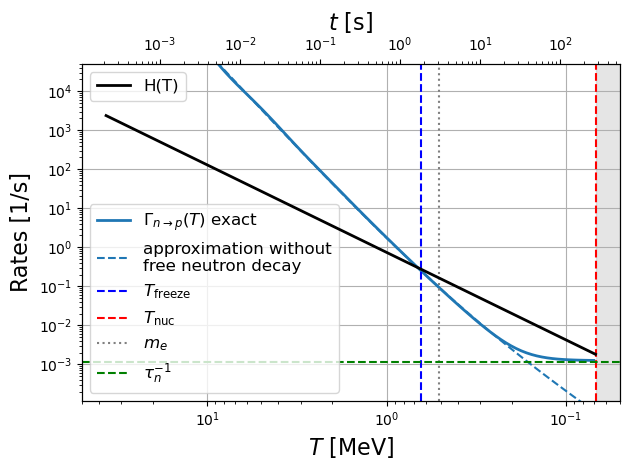

In [558]:
#| label: BBN_Gnp

TT = (np.logspace(np.log10(7e4), np.log10(5e7), 100) * u.eV/ const.k_B).to(u.K)

E = (TT * const.k_B).to(u.MeV)
T_before_me = np.array([T.value for T in TT if (T * const.k_B >= me)])*u.K
T_after_me = np.array([T.value for T in TT if (T * const.k_B <= me)])*u.K

fig = plt.figure()
#plt.plot(tt, np.array([-dXndt(Xnt(t*u.s), t) for t in tt])/u.s, label="$\Gamma_n(T)$")
p = plt.plot(E, np.array([lnp(T).value for T in TT])/u.s, lw=2, label=r"$\Gamma_{n\to p}(T)$ exact")
plt.plot(E, lambda_np_Bernstein(TT), label="approximation without\nfree neutron decay", color=p[0].get_color(), linestyle="--")
#plt.plot(E, np.array([lnp(T).value+lpn(T).value for T in TTT])/u.s, label="$\Gamma_n(T)$")
#plt.plot((T_before_me * const.k_B).to(u.MeV), H(T_before_me, gstar=gstar), lw=2, label="$H(T)$", color="k")
#plt.plot((T_after_me * const.k_B).to(u.MeV), H(T_after_me, gstar=gstar_after), lw=2,color="k")
plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.axvline((Tfreeze * const.k_B).to(u.MeV).value, color="b", linestyle="--", label="$T_\mathrm{freeze}$")
plt.axvline((Tnuc * const.k_B).to(u.MeV).value, color="r", linestyle="--", label="$T_\mathrm{nuc}$")
plt.axvline(me.to(u.MeV).value, linestyle=":", label="$m_e$", color="gray")
plt.axhline(1/taun.value, linestyle="--", label=r"$\tau_n^{-1}$", color="green")
plt.grid()
plt.xlabel("$T$ [MeV]", fontsize=16)
plt.ylabel("Rates [1/s]", fontsize=16)
plt.axvspan((Tnuc * const.k_B).to(u.MeV).value, 5e-2, alpha=0.2, color="gray")  #horizontal shading
plt.xlim((50, 5e-2))
plt.ylim((1e-1/taun.value, 5e4))
plt.legend(fontsize=12, ncol=1, loc="lower left")

secax = plt.gca().twiny()
ttt = T_to_t_Weinberg(TT.value)
secax.plot(ttt, 1/(2*ttt), linestyle="-", color="k", lw=2, label="H(T)")
#secax.plot(ttt, H(t_to_T_Weinberg(ttt.value), gstar=gstar_after), linestyle="-", color="r", lw=2, label="H(T)")
#secax.plot(tt_before_me, H(t_to_T(tt_before_me, gstar=gstar), gstar=gstar), linestyle="-", color="k", lw=2, label="H(T)")
#secax.plot(tt_after_me, H(t_to_T(tt_after_me, gstar=gstar_after), gstar=gstar_after), linestyle="-", color="k", lw=2, label="H(T)")
#secax.plot(tt*u.s, H(t_to_T(tt*u.s, gstar=gstar), gstar=gstar), linestyle="none")
#secax.plot(tt*u.s, H(t_to_T(tt*u.s, gstar=gstar_after), gstar=gstar_after), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [s]', fontsize=16)
secax.legend(fontsize=12, loc="upper left")

fig.tight_layout()
plt.show()

In [44]:
(13.6*u.eV / const.k_B).to(u.K)

<Quantity 157821.44645308 K>

Taux de désintégration du neutron (plateau de la courbe)`

In [198]:
1/(lnp(TTT[-1]).value/u.s)

<Quantity 805.8659363 s>

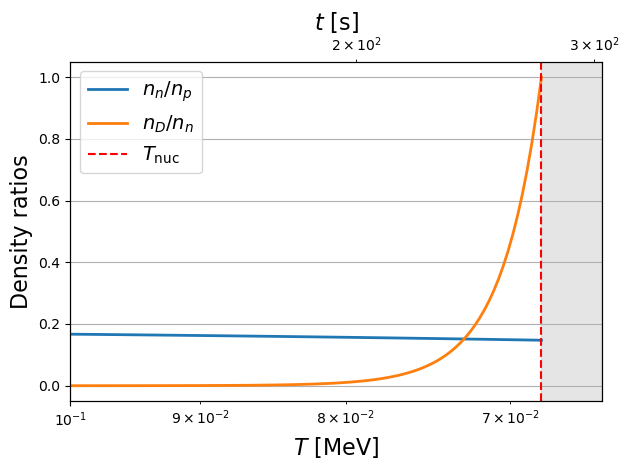

In [555]:
#| label: BBN_Dn

TT = (np.logspace(np.log10((Tnuc * const.k_B).to(u.eV).value), np.log10(1e5), 100) * u.eV/ const.k_B).to(u.K)

fig = plt.figure()
plt.plot((TT*const.k_B).to(u.MeV), ratio_np(TT), lw=2, label=rf"$n_n / n_p$")
plt.plot((TT*const.k_B).to(u.MeV), ratio_Dn(TT), lw=2, label=rf"$n_D / n_n$")
#plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("$T$ [MeV]", fontsize=16)
plt.ylabel("Density ratios", fontsize=16)
#plt.axvline((Tfreeze * const.k_B).to(u.MeV).value, color="b", linestyle="--", label="$T_\mathrm{freeze}$")
plt.axvline((Tnuc * const.k_B).to(u.MeV).value, color="r", linestyle="--", label="$T_\mathrm{nuc}$")
plt.legend(fontsize=14, ncol=1)
plt.axvspan((Tnuc * const.k_B).to(u.MeV).value, 6.5e-2, alpha=0.2, color="gray")  #horizontal shading
plt.xlim((np.max(TT)*const.k_B).to(u.MeV).value, 6.5e-2)
#plt.ylim(0.0, 0.52)
plt.grid()

secax = plt.gca().twiny()
ttt = T_to_t_Weinberg(TT.value)
secax.plot(ttt, Xnt(ttt), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [s]', fontsize=16)
fig.tight_layout()
plt.show()